In [1]:
from data_fns import load_mnist
from estimator import RFClassifier, classical_weights, V1_inspired_weights, relu, parallelized_clf
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
import pickle

In [2]:
import dask
from dask.distributed import Client
client = Client(threads_per_worker=5, n_workers=5)
client

Client Scheduler: tcp://127.0.0.1:41533 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 5 Cores: 25 Memory: 135.06 GB


In [3]:
# load data
X_train, y_train, X_test, y_test = load_mnist('data/mnist')

In [4]:
n_features = sorted(set(np.logspace(0, 3.5, 100).astype('int')))

# weight params
t, l, scale = 5, 3, 1
kwargs = {'t': t, 'l': l, 'scale': scale}
weights_V1 = {'weight_fun': V1_inspired_weights, 'kwargs': kwargs}

kwargs_classical = {'scale': scale}
weights_classical = {'weight_fun': classical_weights, 'kwargs': kwargs_classical}

# params for classification
# sgd = SGDClassifier(loss="squared_hinge", alpha=1, max_iter=200, tol=1e-5, shuffle=True, n_jobs=5,
#                     learning_rate="optimal", early_stopping=True, validation_fraction=0.1, n_iter_no_change=20)
svc = LinearSVC(random_state=20, tol=1e-4, max_iter=200)
b = np.mean(la.norm(X_train)/ np.sqrt(X_train.shape[0]))

In [ ]:
%%time
results = {}
m = np.zeros_like(n_features, dtype='float')
results['classical'] = {'avg_test_err': m.copy(), 'std_test_err': m.copy()}
results['V1'] = {'avg_test_err': m.copy(), 'std_test_err': m.copy()}
for i, n in enumerate(n_features):

    # classical random features
    params_classical = {'width': n, **weights_classical, 'bias': b, 'nonlinearity': relu, 'clf': svc}
    _, _, results['classical']['avg_test_err'][i], results['classical']['std_test_err'][i] = parallelized_clf(RFClassifier, 
                                                                                                    params_classical, 
                                                                                                    X_train, y_train, 
                                                                                                    X_test, y_test, 
                                                                                                    n_iters=5)
    
    # haltere inspired
    params_V1 = {'width': n, **weights_V1, 'bias': b, 'nonlinearity': relu, 'clf': svc} 
    _, _, results['V1']['avg_test_err'][i], results['V1']['std_test_err'][i] = parallelized_clf(RFClassifier, 
                                                                                                params_V1, 
                                                                                                X_train, y_train, 
                                                                                                X_test, y_test, 
                                                                                                n_iters=5)

    print('Iter: %d/%d, V1 test err%0.2f, RF test err %0.2f' % (n, n_features[-1],  
                                                                       results['V1']['avg_test_err'][i],
                                                                      results['classical']['avg_test_err'][i]))
    
with open('results/mnist_clf/mnist_clf_t=%0.2f_l=%0.2f_svc.pickle' % (t, l), 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL) 

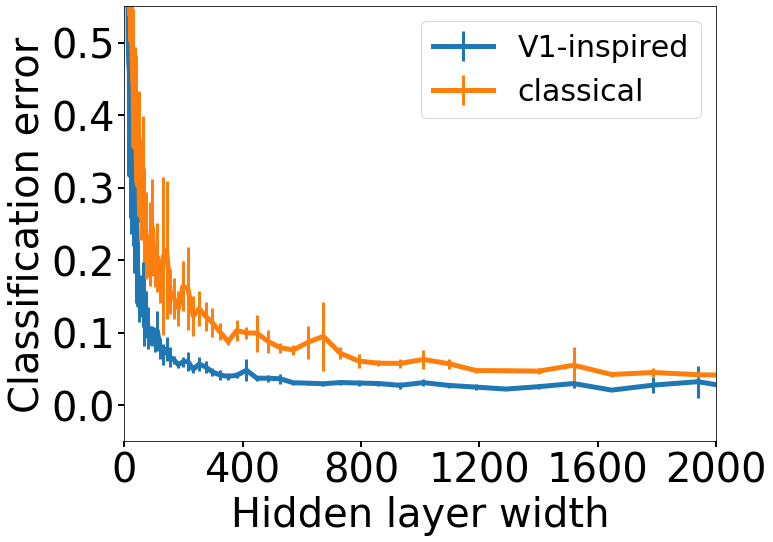

In [6]:
with open('results/mnist_clf/mnist_clf_t=%0.2f_l=%0.2f_svc.pickle' % (t, l), 'rb') as handle:
    results = pickle.load(handle)
    
fig = plt.figure(figsize=(10.6, 8))
ax = fig.add_subplot(111)
ax.errorbar(n_features, results['V1']['avg_test_err'], yerr=results['V1']['std_test_err'], fmt='-', 
            label='V1-inspired',  markersize=4, lw=5, elinewidth=3)
ax.errorbar(n_features, results['classical']['avg_test_err'], yerr=results['classical']['std_test_err'], 
            fmt='-', label='classical', markersize=4, lw=5, elinewidth=3)
plt.xlabel('Hidden layer width', fontsize=40)
plt.ylabel('Classification error', fontsize=40)
plt.xlim([0, 2000])
plt.yticks(np.arange(0, 0.6, 0.1))
plt.ylim([-0.05, 0.55])
plt.xticks(np.arange(0, 2200, 400))
ax.tick_params(axis = 'both', which = 'major', labelsize = 40, width=2, length=6)

plt.legend(loc = 'upper right', fontsize=30)
plt.savefig('results/mnist_clf/mnist_clf_t=%0.2f_l=%0.2f.png' % (t, l))

In [ ]:
# list(zip(n_features, results['classical']['avg_test_err']))

In [ ]:
# list(zip(n_features, results['V1']['avg_test_err']))

### Few shot learning

In [ ]:
train, train_labels, test, test_labels = load_mnist('data/mnist')
num_train = 50
X_train, _, y_train, _ = train_test_split(train, train_labels, train_size=num_train, stratify=train_labels, 
                                          random_state=42)
X_test, y_test = test.copy(), test_labels.copy()

In [ ]:
n_features = sorted(set(np.logspace(0, 3.5, 100).astype('int')))

# weight params
t, l, scale = 5, 3, 1
kwargs = {'t': t, 'l': l, 'scale': scale}
weights_V1 = {'weight_fun': V1_inspired_weights, 'kwargs': kwargs}

kwargs_classical = {'scale': scale}
weights_classical = {'weight_fun': classical_weights, 'kwargs': kwargs_classical}

# params for classification
# sgd = SGDClassifier(loss="squared_hinge", alpha=1, max_iter=200, tol=1e-5, shuffle=True, n_jobs=5,
#                     learning_rate="optimal", early_stopping=True, validation_fraction=0.2, n_iter_no_change=20)
svc = LinearSVC(random_state=20, tol=1e-4, max_iter=200)

b = np.mean(la.norm(X_train)/ np.sqrt(X_train.shape[0]))

In [ ]:
%%time
results = {}
m = np.zeros_like(n_features, dtype='float')
results['classical'] = {'avg_test_err': m.copy(), 'std_test_err': m.copy()}
results['V1'] = {'avg_test_err': m.copy(), 'std_test_err': m.copy()}
for i, n in enumerate(n_features):

    # classical random features
    params_classical = {'width': n, **weights_classical, 'bias': b, 'nonlinearity': relu, 'clf': svc}
    _, _, results['classical']['avg_test_err'][i], results['classical']['std_test_err'][i] = parallelized_clf(RFClassifier, 
                                                                                                    params_classical, 
                                                                                                    X_train, y_train, 
                                                                                                    X_test, y_test, 
                                                                                                    n_iters=5)
    
    # haltere inspired
    params_V1 = {'width': n, **weights_V1, 'bias': b, 'nonlinearity': relu, 'clf': svc} 
    _, _, results['V1']['avg_test_err'][i], results['V1']['std_test_err'][i] = parallelized_clf(RFClassifier, 
                                                                                                params_V1, 
                                                                                                X_train, y_train, 
                                                                                                X_test, y_test, 
                                                                                                n_iters=5)

    print('Iter: %d/%d' % (i, len(n_features)))
    
with open('results/mnist_clf/mnist_clf_t=%0.2f_l=%0.3f_few_shot_svc.pickle' % (t, l), 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

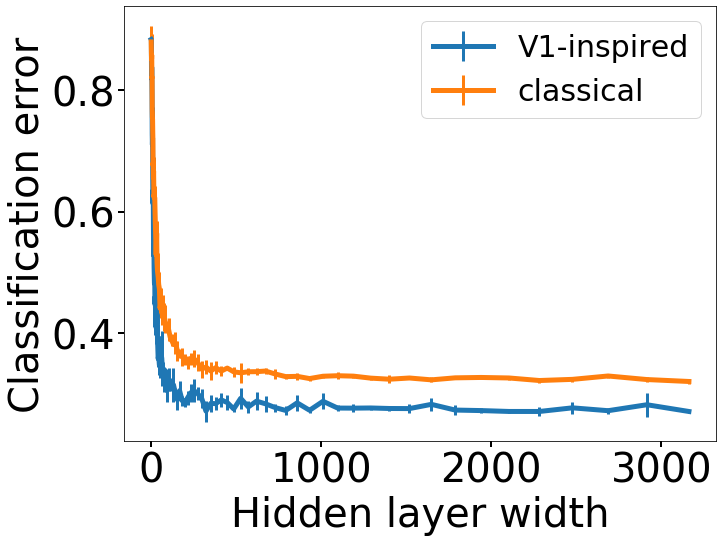

In [7]:
with open('results/mnist_clf/mnist_clf_t=%0.2f_l=%0.3f_few_shot_svc.pickle' % (t, l), 'rb') as handle:
    results = pickle.load(handle)

fig = plt.figure(figsize=(10.6, 8))
ax = fig.add_subplot(111)
ax.errorbar(n_features, results['V1']['avg_test_err'], yerr=results['V1']['std_test_err'], fmt='-', 
            label='V1-inspired',  markersize=4, lw=5, elinewidth=3)
ax.errorbar(n_features, results['classical']['avg_test_err'], yerr=results['classical']['std_test_err'], 
            fmt='-', label='classical', markersize=4, lw=5, elinewidth=3)
plt.xlabel('Hidden layer width', fontsize=40)
plt.ylabel('Classification error', fontsize=40)
# plt.xticks(np.arange(0, 1020, 200))
# plt.xlim([0, 1000])
# plt.yticks(np.arange(0, 0.6, 0.1))
# plt.ylim([-0.05, 0.55])
# plt.xticks(np.arange(0, 255, 50))
ax.tick_params(axis = 'both', which = 'major', labelsize = 40, width=2, length=6)

plt.legend(loc = 'upper right', fontsize=30)
plt.savefig('results/mnist_clf/mnist_clf_t=%0.2f_l=%0.2f_fewshot.png' % (t, l))

In [8]:
list(zip(n_features, results['classical']['avg_test_err']))

[(1, 0.8793599999999999),
 (2, 0.8612799999999998),
 (3, 0.85138),
 (4, 0.8575800000000001),
 (5, 0.82046),
 (6, 0.82136),
 (7, 0.76986),
 (8, 0.7555400000000001),
 (9, 0.7515000000000001),
 (10, 0.73124),
 (11, 0.71672),
 (12, 0.67588),
 (13, 0.68068),
 (14, 0.6562),
 (15, 0.6667),
 (17, 0.6239),
 (18, 0.62746),
 (20, 0.6232),
 (22, 0.62294),
 (23, 0.6072200000000001),
 (25, 0.58384),
 (28, 0.5529200000000001),
 (30, 0.52898),
 (33, 0.5643199999999999),
 (35, 0.51678),
 (38, 0.50202),
 (42, 0.49222),
 (45, 0.4801),
 (49, 0.47308000000000006),
 (53, 0.44092000000000003),
 (58, 0.45031999999999994),
 (63, 0.43314),
 (68, 0.43948),
 (74, 0.42728),
 (81, 0.42306),
 (87, 0.41088),
 (95, 0.41122000000000003),
 (103, 0.40632),
 (112, 0.39405999999999997),
 (121, 0.3886),
 (132, 0.3814800000000001),
 (143, 0.38381999999999994),
 (155, 0.37105999999999995),
 (168, 0.3671),
 (183, 0.36126),
 (198, 0.3567),
 (215, 0.35153999999999996),
 (233, 0.35824),
 (253, 0.3578799999999999),
 (275, 0.35152)

In [9]:
list(zip(n_features, results['V1']['avg_test_err']))

[(1, 0.8834799999999999),
 (2, 0.883),
 (3, 0.8192),
 (4, 0.83772),
 (5, 0.82004),
 (6, 0.78784),
 (7, 0.7274),
 (8, 0.7101),
 (9, 0.72112),
 (10, 0.65402),
 (11, 0.61388),
 (12, 0.62188),
 (13, 0.63556),
 (14, 0.5795399999999999),
 (15, 0.52838),
 (17, 0.54574),
 (18, 0.5089),
 (20, 0.48192),
 (22, 0.48274),
 (23, 0.44758),
 (25, 0.46046),
 (28, 0.41034000000000004),
 (30, 0.45508000000000004),
 (33, 0.41432),
 (35, 0.43994),
 (38, 0.39148),
 (42, 0.35804),
 (45, 0.36422),
 (49, 0.34756),
 (53, 0.34692),
 (58, 0.36724),
 (63, 0.35874000000000006),
 (68, 0.3356),
 (74, 0.32348000000000005),
 (81, 0.32480000000000003),
 (87, 0.32211999999999996),
 (95, 0.30896),
 (103, 0.32378),
 (112, 0.31562),
 (121, 0.31472),
 (132, 0.3149),
 (143, 0.30104000000000003),
 (155, 0.29032),
 (168, 0.30535999999999996),
 (183, 0.28902),
 (198, 0.28586),
 (215, 0.29356),
 (233, 0.30188),
 (253, 0.30542),
 (275, 0.30019999999999997),
 (298, 0.29252),
 (323, 0.27170000000000005),
 (351, 0.28446),
 (380, 0.28